In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import multiprocessing as mp

### Carregando Dados

In [2]:
path = os.path.join('VendasTesouroDireto_1.json')
values = pd.read_json(path)
df_data = pd.DataFrame(values)
df_data['Tipo_Titulo'] = df_data['Tipo_Titulo'].astype('str') 
df_data['PU'] = df_data['PU'].str.replace(',', '.')
df_data['Quantidade'] = df_data['Quantidade'].str.replace(',', '.')
df_data['Valor'] = df_data['Valor'].str.replace(',', '.')
df_data['PU'] = pd.to_numeric(df_data['PU'], errors='coerce')
df_data['Quantidade'] = pd.to_numeric(df_data['Quantidade'], errors='coerce')
df_data['Valor'] = pd.to_numeric(df_data['Valor'], errors='coerce')
df_data['Vencimento_do_Titulo'] = pd.to_datetime(df_data['Vencimento_do_Titulo'])
df_data['Data_Venda'] = pd.to_datetime(df_data['Data_Venda'])


df_data

,Tipo_Titulo,Vencimento_do_Titulo,Data_Venda,PU,Quantidade,Valor
0,Tesouro IPCA+ com Juros Semestrais,2012-08-15,2008-05-12,1655.206735,38.6,63890.97
1,Tesouro IPCA+ com Juros Semestrais,2017-05-15,2008-05-12,1480.154343,571.0,845168.12
2,Tesouro Prefixado com Juros Semestrais,2014-01-01,2008-05-12,870.303177,283.2,246469.85
3,Tesouro Prefixado com Juros Semestrais,2012-01-01,2008-05-12,936.285273,29.2,27339.52
4,Tesouro Prefixado com Juros Semestrais,2017-01-01,2008-05-12,808.587250,491.8,397663.20
...,...,...,...,...,...,...
66164,Tesouro Prefixado com Juros Semestrais,2010-01-01,2008-08-27,960.339019,110.2,105829.35
66165,Tesouro IPCA+ com Juros Semestrais,2010-08-15,2008-08-27,1672.613421,271.2,453612.75
66166,Tesouro IPCA+ com Juros Semestrais,2011-05-15,2008-08-27,1677.517573,88.2,147957.04
66167,Tesouro Prefixado com Juros Semestrais,2010-01-07,2008-08-27,946.566666,0.6,567.93


### Visualizando, filtrando e organizando Dados

[]

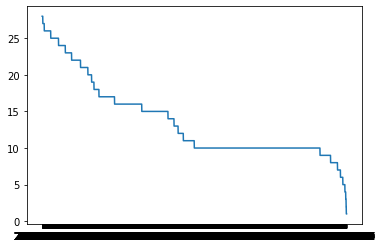

In [3]:
dftwo = df_data['Data_Venda'].value_counts().rename_axis('Data_Venda').reset_index(name='counts')
dftwo['Data_Venda'] = dftwo['Data_Venda'].astype(str)


x=dftwo['Data_Venda']
y=dftwo['counts']
plt.plot(x,y)
plt.plot()

In [4]:
pu = df_data['Quantidade']
# será se deve ser essas colunas mesmo?
df_features = df_data.drop(columns=['Tipo_Titulo', 'Vencimento_do_Titulo', 'Data_Venda', 'Quantidade'])

df_features

,PU,Valor
0,1655.206735,63890.97
1,1480.154343,845168.12
2,870.303177,246469.85
3,936.285273,27339.52
4,808.587250,397663.20
...,...,...
66164,960.339019,105829.35
66165,1672.613421,453612.75
66166,1677.517573,147957.04
66167,946.566666,567.93


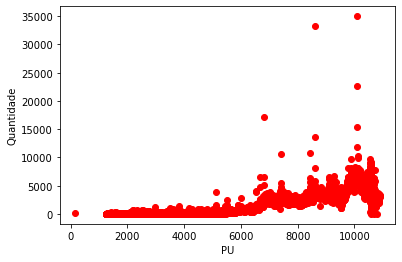

In [5]:
#df_datapu = [x for i, x  in enumerate(df_data['PU']) if i < 1000]
#df_dataqtd = [x for i, x  in enumerate(df_data['Quantidade']) if i < 1000]

#plt.scatter(df_datapu, df_dataqtd)
df_dados_c0=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado com Juros Semestrais']
df_dados_c1=df_data[df_data['Tipo_Titulo']=='Tesouro Selic']
df_dados_c2=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado']
df_dados_c3=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado IPCA+']
df_dados_c4=df_data[df_data['Tipo_Titulo']=='Tesouro IGPM+ com Juros Semestrais']
df_dados_c5=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado IPCA+ com Juros Semestrais']

#plt.scatter(df_dados_c0['PU'], df_dados_c0['Quantidade'],c='blue')
plt.scatter(df_dados_c1['PU'], df_dados_c1['Quantidade'],c='red')
#plt.scatter(df_dados_c2['PU'], df_dados_c2['Quantidade'],c='green')
#plt.scatter(df_dados_c3['PU'], df_dados_c3['Quantidade'],c='purple')
#plt.scatter(df_dados_c4['PU'], df_dados_c4['Quantidade'],c='yellow')
#plt.scatter(df_dados_c5['PU'], df_dados_c5['Quantidade'],c='red')


plt.xlabel('PU')
plt.ylabel('Quantidade')
# pode-se observar que quanto menor o preço unitário, maior é a quantidade vendida
plt.show()

In [6]:
df_features_c1=df_dados_c1.drop(columns=['Tipo_Titulo','Data_Venda','Vencimento_do_Titulo'])
df_features_c1_datas = df_dados_c1.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo'])
df_features_c1

,PU,Quantidade,Valor
6,3694.700000,83.2,307399.04
9,3692.770059,133.6,493354.07
27,3728.658416,140.2,522757.90
32,3726.728894,39.8,148323.80
47,3730.540024,409.0,1525790.86
...,...,...,...
66128,3534.769820,100.4,354890.88
66138,3566.330371,75.4,268901.30
66144,3567.210000,76.0,271107.96
66162,3568.050000,175.4,625835.97


In [7]:
future_dates = df_features_c1_datas['Data_Venda']
first = min(df_features_c1_datas['Data_Venda'])
last = max(df_features_c1_datas['Data_Venda'])
diff = last - first
future_dates = future_dates + np.timedelta64(diff)
future_dates

6       2028-04-16
9       2028-04-16
27      2029-01-06
32      2029-01-06
47      2029-04-05
           ...    
66128   2028-07-04
66138   2028-07-31
66144   2028-07-31
66162   2028-08-01
66168   2028-08-01
Name: Data_Venda, Length: 7957, dtype: datetime64[ns]

In [8]:
# exemplo de filtro por intervalo de datas
def filter_interval (data_frame, min_dt, max_dt):
    min_date = np.datetime64(min_dt)
    max_date = np.datetime64(max_dt)
    filtered = [x for x in data_frame if x < max_date and x > min_date]
    return pd.DataFrame({'filtered': filtered})

def removable_indexes (data_frame, min_dt, max_dt):
    min_date = np.datetime64(min_dt)
    max_date = np.datetime64(max_dt)
    return [i for i, x in enumerate(data_frame) if x >= max_date or x <= min_date]

def remove_indexes (data_frame, indexes):
    return [x for i, x in enumerate(data_frame) if i not in indexes]

r = filter_interval(df_features_c1_datas['Data_Venda'], '2008-05-01', '2008-05-30')
r

,filtered
0,2008-05-12
1,2008-05-12
2,2008-05-11
3,2008-05-11
4,2008-05-23
5,2008-05-23
6,2008-05-09
7,2008-05-09
8,2008-05-06
9,2008-05-06


In [9]:
x1 = len(df_features_c1_datas['Data_Venda'])
x2 = len(df_features_c1['PU'])
if x1 != x2:
    raise Exception(f'{x1} is not equal to {x2}')

### Treinando modelo

In [10]:
def getModel():
    #return LinearRegression() # resultados menos efetivos, porém instantaneos e requer pouco processamento
    return RandomForestRegressor() # resultados melhores mas requer muito processamento

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_features.values, pu, test_size=0.2)
# pq está tão baixo?

model = getModel().fit(X_train, y_train)

score = model.score(X_test,y_test)

score

0.9918897843978658

In [12]:
#Tentando fazer o training com df_dados_c1(seriam os dados redimencionados para f1 e f2 dos tesouros de tipo Selic)
pu_selic=df_dados_c1['PU']
data_selic=df_dados_c1['Data_Venda']
X_train, X_test, y_train, y_test = train_test_split(df_features_c1.values, pu_selic, test_size=0.2)
model = getModel().fit(X_train, y_train)

score = model.score(X_test,y_test)

score

0.9999101979757172

In [13]:
model.predict(X_train)

array([3551.96864476, 5611.0256997 , 2309.56222617, ..., 1459.1503568 ,
       8811.4264804 , 1446.69007246])

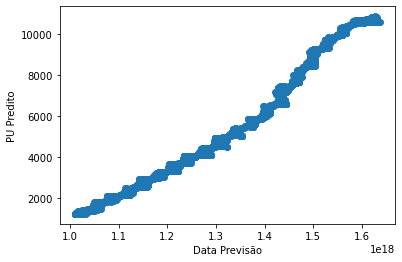

In [14]:
pû_selic = cross_val_predict(getModel(),df_features_c1.values,  pu_selic, cv = 20)
datâ_selic = cross_val_predict(getModel(),df_features_c1.values,  data_selic, cv = 20)
datas = df_dados_c1['Data_Venda']
plt.scatter(datâ_selic, pû_selic)

plt.xlabel('Data Previsão')
plt.ylabel('PU Predito')

plt.show()

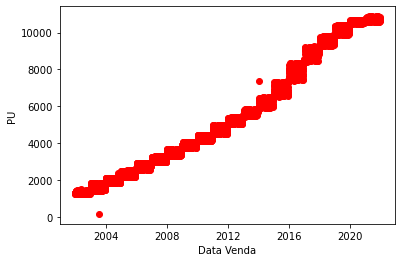

6365

In [15]:
plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')

plt.ylabel('PU')
plt.xlabel('Data Venda')
plt.show()
len(model.predict(X_train))

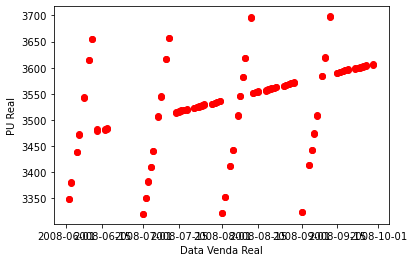

6365

In [16]:
min_date = '2008-06-01'
max_date = '2008-09-30'
filtered_sell_date = filter_interval(df_features_c1_datas['Data_Venda'], min_date, max_date)
pu_invalid_indexes = removable_indexes(df_features_c1_datas['Data_Venda'], min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(df_features_c1['PU'], pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Real')
plt.xlabel('Data Venda Real')
plt.show()
len(model.predict(X_train))

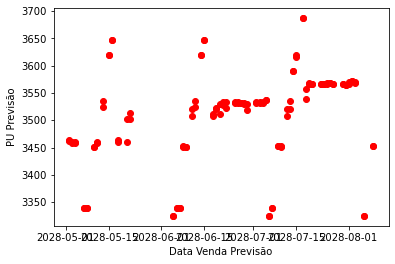

6365

In [17]:
min_date = '2028-05-01'
max_date = '2028-08-10'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))


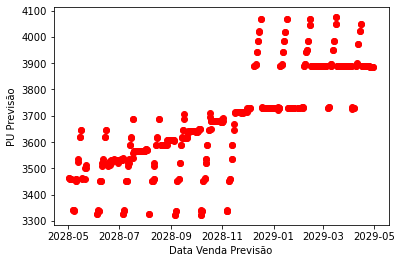

6365

In [18]:
min_date = '2028-05-01'
max_date = '2029-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

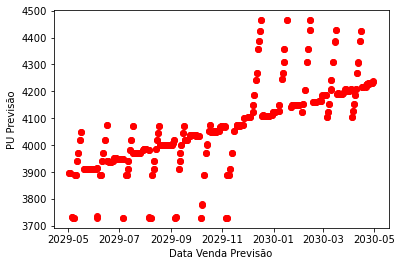

6365

In [19]:
min_date = '2029-05-01'
max_date = '2030-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

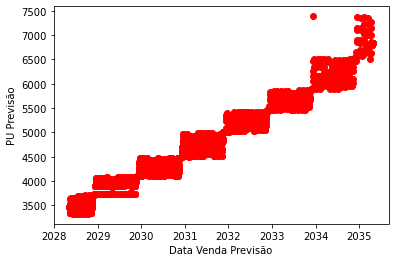

6365

In [20]:
min_date = '2028-05-01'
max_date = '2035-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

In [21]:
aux=df_data.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo','PU'])
data_Value_Per_Month=pd.DataFrame(aux.groupby(aux['Data_Venda'].dt.to_period('m'))['Valor'].sum())

data_Value_Per_Month

,Valor
Data_Venda,
2002-01,6.328324e+06
2002-02,8.735493e+06
2002-03,6.765776e+06
2002-04,5.573925e+06
2002-05,5.169537e+06
...,...
2021-08,6.869948e+08
2021-09,5.864650e+08
2021-10,5.798824e+08


### Validando dados

In [22]:
scores = cross_val_score(getModel(), df_features.values, pu, cv = 10)
# pq está tão baixo?
print('R2=',np.mean(scores))

R2= 0.9659062615754566


### Verificando correlação

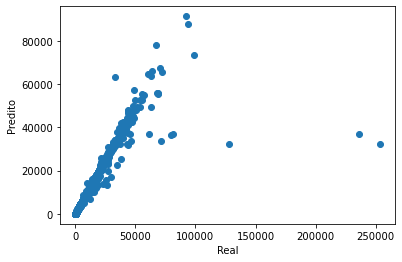

In [23]:
pû = cross_val_predict(getModel(), df_features.values, pu, cv = 20)
plt.scatter(pu, pû)

plt.xlabel('Real')
plt.ylabel('Predito')

plt.show()

In [24]:
pû_selic

array([3687.00255782, 3686.57405333, 3731.50880755, ..., 3565.42418075,
       3566.55121804, 3571.06155618])

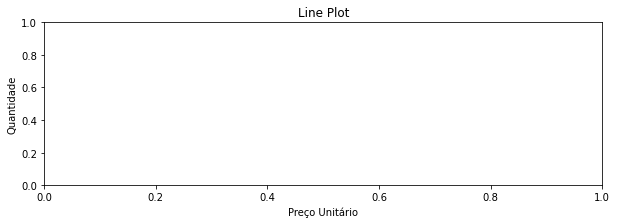

0        False
1        False
2        False
3        False
4        False
         ...  
66164    False
66165    False
66166    False
66167    False
66168     True
Name: Tipo_Titulo, Length: 66169, dtype: bool

In [25]:
fig=plt.figure(figsize=(10,3))
isSelic = df_data['Tipo_Titulo'] == "Tesouro Selic"
#if df_data.isSelic == true:
 #   plt.plot(df_data['PU'][isSelic],df_data['Quantidade'][isSelic])

plt.title('Line Plot')
plt.xlabel('Preço Unitário')
plt.ylabel('Quantidade')
#df_data['PU'][isSelic].value_counts()
plt.show()

isSelic

<AxesSubplot:title={'center':'Valor Total Mensal'}, xlabel='Data_Venda', ylabel='Valor'>

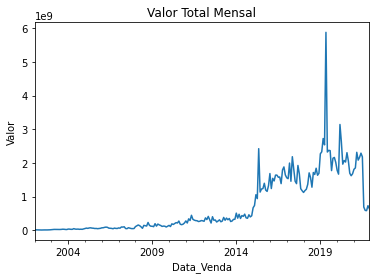

In [26]:
#Aqui temos a serie
plt.xlabel('Meses')
plt.ylabel('Valor')
plt.title('Valor Total Mensal')

data_Value_Per_Month['Valor'].plot()

In [27]:
aux=df_data.drop(columns=['Vencimento_do_Titulo','PU','Quantidade'])
aux.set_index('Data_Venda')
data_Value_Per_Month_Selic=pd.DataFrame(aux[aux['Tipo_Titulo']=='Tesouro Selic'].groupby(aux['Data_Venda'].dt.to_period('m'))['Valor'].sum())
data_Value_Per_Month_Selic

,Valor
Data_Venda,
2002-01,4.304474e+05
2002-02,4.275074e+05
2002-03,4.252652e+05
2002-04,3.193325e+05
2002-05,7.717556e+05
...,...
2021-08,2.831883e+08
2021-09,2.305479e+08
2021-10,2.219307e+08


<AxesSubplot:title={'center':'Valor Total Mensal(Selic)'}, xlabel='Data_Venda', ylabel='Valor'>

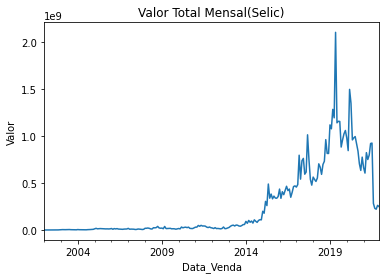

In [28]:
plt.xlabel('Meses')
plt.ylabel('Valor')
plt.title('Valor Total Mensal(Selic)')

data_Value_Per_Month_Selic['Valor'].plot()

In [29]:
data_Value_Per_Month.index=data_Value_Per_Month.index.to_timestamp()

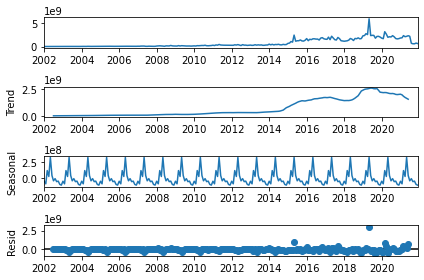

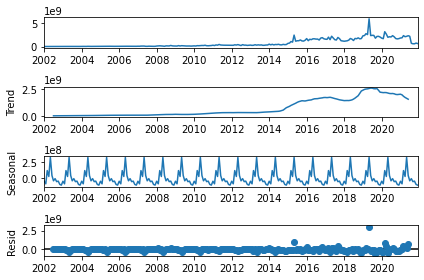

In [30]:
#Seasonal decompese nos da mais detalhes do comportamento da serie ao longo do tempos
result = seasonal_decompose(data_Value_Per_Month)
result.plot()
#Pode se ver que o dado e claramente afetado por estações,a trend esta agora apontando levemente para baixo

In [31]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_Value_Per_Month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue



Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10635.861719197761
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10018.759992699856
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:9788.917708400986
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:9260.447288363088
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:9828.338756280438
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:9762.504925319023
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:9300.728799062294
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:9260.113048072699
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10461.377182670178
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:9911.21288706924
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:9711.716408391636
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:9167.849173645809
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:9966.652618457261
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:9872.92579678847
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 -

In [32]:
#Pegamos a configuração que deu o menor AIC (Akaike Information Critera)
mod = sm.tsa.statespace.SARIMAX(data_Value_Per_Month,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5918      0.037    -15.992      0.000      -0.664      -0.519
ma.S.L12      -0.8664      0.032    -26.944      0.000      -0.929      -0.803
sigma2      2.273e+17   5.18e-20   4.39e+36      0.000    2.27e+17    2.27e+17


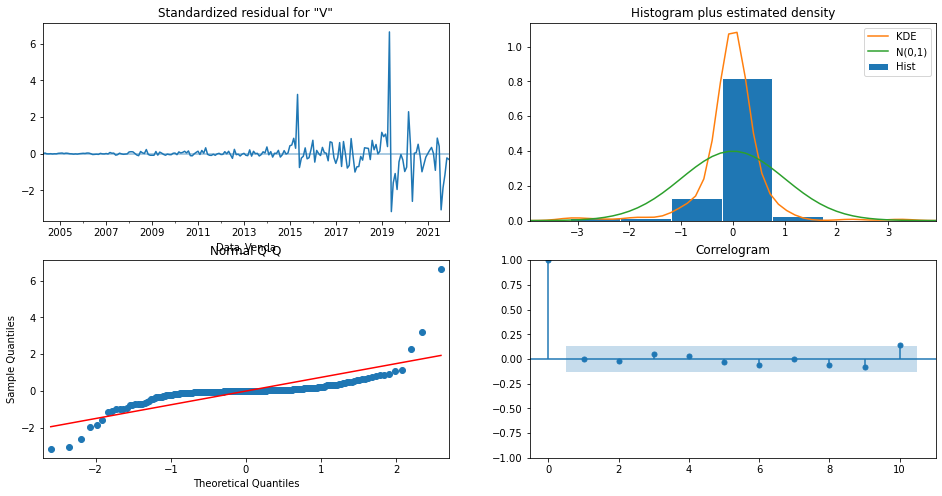

In [33]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

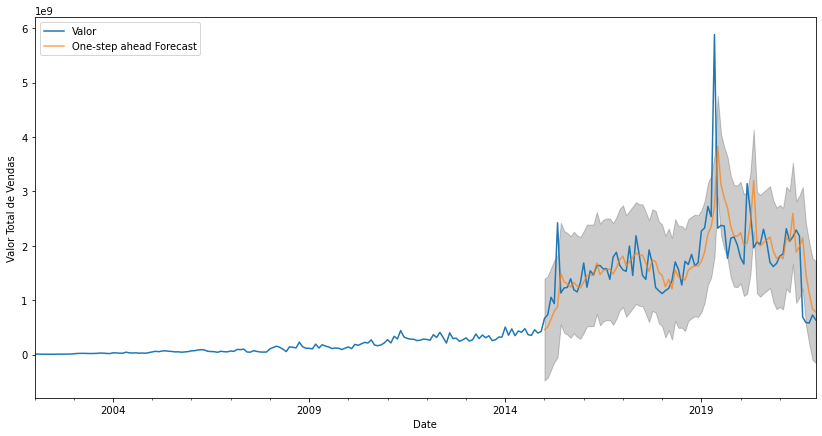

In [34]:
#Nesse grafico podemos ver prediçoes com o ARIMA
#No caso observando o nosso grafico o modelo começa a tentar preve a partir de janeiro de 2015 um mes a frente do real
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data_Value_Per_Month['2002':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Valor Total de Vendas')
plt.legend()
plt.show()

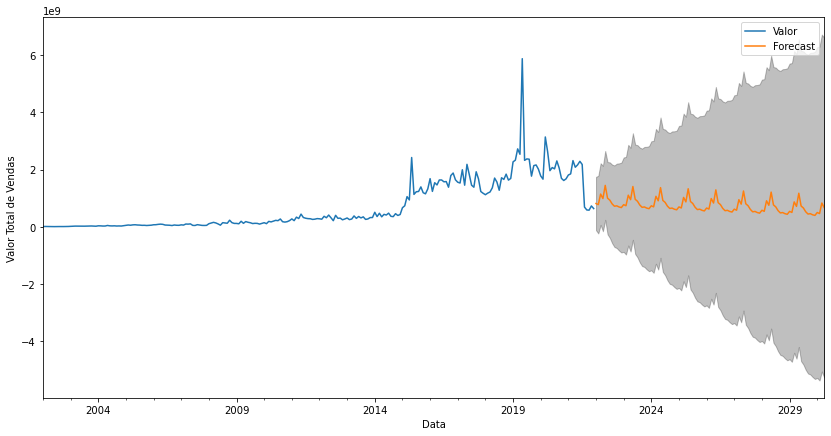

In [35]:
#Aqui temos uma predição de 100 meses no futuro
#A areá cinza conta como uma margem de erro imagino
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = data_Value_Per_Month.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Valor Total de Vendas')
plt.legend()
plt.show()
#Talves as vendas baixa antes de 2015 estejam enviezando?

In [36]:
aux=df_data.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo','PU'])
data_Value_Total=pd.DataFrame(aux.groupby(aux['Data_Venda'])['Valor'].sum())

data_Value_Total['Quantidade']=(aux.groupby(aux['Data_Venda'])['Quantidade'].sum())
data_Value_Total['Dia'] = data_Value_Total.index.day
data_Value_Total['Mes'] = data_Value_Total.index.month
data_Value_Total['Ano'] = data_Value_Total.index.year

data_Value_Total



,Valor,Quantidade,Dia,Mes,Ano
Data_Venda,,,,,
2002-01-02,2.642808e+05,308.20,2,1,2002
2002-01-03,5.202140e+05,580.00,3,1,2002
2002-01-04,1.614084e+05,178.00,4,1,2002
2002-01-07,2.074660e+05,215.40,7,1,2002
2002-01-08,1.670998e+05,164.20,8,1,2002
...,...,...,...,...,...
2021-12-02,7.503926e+07,32814.54,2,12,2021
2021-12-03,1.014572e+08,48250.70,3,12,2021
2021-12-04,1.091209e+08,51381.66,4,12,2021


In [37]:
time_steps = 365  #TAMANHO DA JANELA
test_size = 120  #HORIZONTE DE PREVISÃO

train_size = int(len(data_Value_Total)-(test_size))
train, test = data_Value_Total.iloc[0:train_size], data_Value_Total.iloc[(train_size-time_steps):len(data_Value_Total)]
print(len(train), len(test))
test


4722 485


,Valor,Quantidade,Dia,Mes,Ano
Data_Venda,,,,,
2019-08-27,9.943717e+07,44782.82,27,8,2019
2019-08-28,8.520779e+07,39621.63,28,8,2019
2019-08-29,8.343504e+07,34933.26,29,8,2019
2019-08-30,8.864933e+07,39041.02,30,8,2019
2019-09-01,1.489741e+08,71732.11,1,9,2019
...,...,...,...,...,...
2021-12-02,7.503926e+07,32814.54,2,12,2021
2021-12-03,1.014572e+08,48250.70,3,12,2021
2021-12-04,1.091209e+08,51381.66,4,12,2021


In [38]:
def getModel():
    
    #return LinearRegression()
    return DecisionTreeRegressor()
    #return RandomForestRegressor(n_jobs=mp.cpu_count())

In [46]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    X.info()
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),0].to_numpy()
        v = np.append(v,X.iloc[i + time_steps,1])#Valor
        v = np.append(v,X.iloc[i + time_steps,2])#dia
        v = np.append(v,X.iloc[i + time_steps,3])#mes
        v = np.append(v,X.iloc[i + time_steps,4])#ano
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train['Valor'], time_steps)
X_test, y_test = create_dataset(test, test['Valor'], time_steps)

print(len(X_train), len(X_test))

X_train[0]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4722 entries, 2002-01-02 to 2021-03-02
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Valor       4722 non-null   float64
 1   Quantidade  4722 non-null   float64
 2   Dia         4722 non-null   int64  
 3   Mes         4722 non-null   int64  
 4   Ano         4722 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 221.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 485 entries, 2019-08-27 to 2021-12-07
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Valor       485 non-null    float64
 1   Quantidade  485 non-null    float64
 2   Dia         485 non-null    int64  
 3   Mes         485 non-null    int64  
 4   Ano         485 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 22.7 KB
4357 120


array([2.64280840e+05, 5.20213980e+05, 1.61408350e+05, 2.07466020e+05,
       1.67099810e+05, 1.61267310e+05, 1.10159180e+06, 8.57998200e+04,
       3.14863270e+05, 2.34809040e+05, 4.24967960e+05, 3.35193410e+05,
       1.76569340e+05, 1.81883770e+05, 2.67397030e+05, 2.10775260e+05,
       4.24959070e+05, 1.02784310e+05, 1.67212260e+05, 3.66221500e+05,
       4.51559970e+05, 2.89769710e+05, 1.54626820e+05, 1.13205800e+05,
       2.02651810e+05, 3.38655070e+05, 1.21727633e+06, 6.70419920e+05,
       2.21282670e+05, 3.40673100e+05, 6.08537600e+05, 1.61644150e+05,
       5.69605910e+05, 4.05770450e+05, 5.85261720e+05, 4.86800060e+05,
       4.84440320e+05, 5.69300360e+05, 6.81425690e+05, 6.34145360e+05,
       7.15455300e+04, 3.33128860e+05, 6.10960320e+05, 4.16767500e+04,
       4.93298360e+05, 1.05713785e+06, 8.93869010e+05, 4.78151200e+05,
       3.76757300e+05, 1.97646150e+05, 4.60019330e+05, 4.94150520e+05,
       2.19626920e+05, 2.19792920e+05, 1.37459540e+05, 5.07152580e+05,
      

In [47]:
model = getModel().fit(X_train,y_train)

In [48]:
model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [49]:
preds = []

base_teste = np.copy(X_test)

for i in range(len(base_teste)):
    y_pred = model.predict(np.array([base_teste[i]]))[0]

    preds.append(y_pred)
    
    for k in range(len(preds)):
        
        if i<len(base_teste):
            if k < time_steps:
                if(i<len(base_teste)-1):
                    base_teste[i+1][(time_steps-1)-k] = preds[(len(preds)-1)-k]

len(preds)

120

In [50]:
dados_real = data_Value_Total.iloc[(train_size):len(data_Value_Total),0].to_numpy()

len(dados_real)

df_real_predito = pd.DataFrame({'real':dados_real,'predito':preds})

df_real_predito

,real,predito
0,3.418794e+08,2.375641e+08
1,8.988370e+07,7.463576e+07
2,1.968712e+08,1.488114e+08
3,1.045174e+08,8.676082e+07
4,1.156872e+08,8.676082e+07
...,...,...
115,7.503926e+07,9.711342e+07
116,1.014572e+08,9.760833e+07
117,1.091209e+08,1.179498e+08
118,1.028062e+08,1.132932e+08


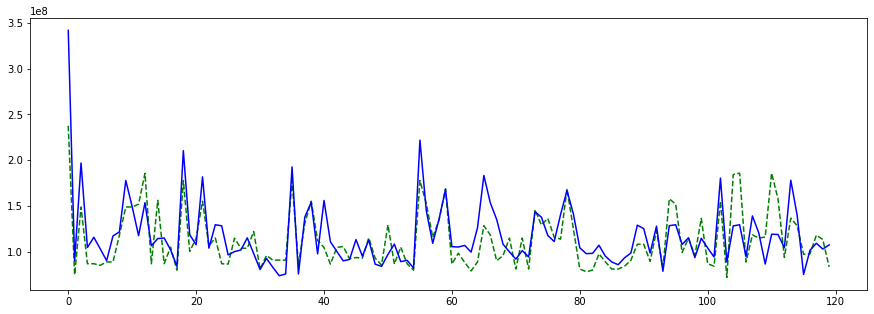

In [51]:
plt.figure(figsize=(15,5))
# plt.plot(range(len(y_train)),y_train, 'g--')
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--')
plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b')
# plt.xlim(0,30)
plt.show()

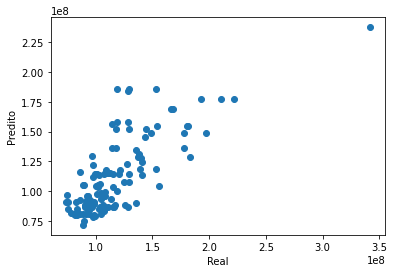

rmse= 24080048.592586726
mae= 17748273.925750002
r2= 0.5542040281303025


In [52]:
plt.scatter(df_real_predito['real'],df_real_predito['predito'])

plt.xlabel('Real')
plt.ylabel('Predito')
#plt.xlim(0,10)

plt.show()

print('rmse=',sqrt(mean_squared_error(df_real_predito['real'].array,df_real_predito['predito'].array)))
print('mae=',mean_absolute_error(df_real_predito['real'].array,df_real_predito['predito'].array))
#print('mape=',mean_absolute_percentage_error(df_real_predito['real'].array,df_real_predito['predito'].array))
print('r2=',r2_score(df_real_predito['real'].array,df_real_predito['predito'].array))